**SEAS6414_HW6_Cubero**

**Question 1**
Objective:
Apply and evaluate supervised learning techniques for sentiment analysis in the financial
sector, enhancing skills in data preprocessing, exploratory analysis, and evaluating
machine learning models based on multiple performance metrics.

Background:

The utilization of statistical techniques in financial sentiment analysis is often limited due
to complexities in practical applications and a shortage of high-quality training data.

In finance and economics texts, where annotated datasets are scarce and largely proprietary,
this challenge becomes more pronounced. To address this, a collection of approximately
5000 sentences has been compiled to establish benchmarks for various modeling techniques.

Dataset:
The original Financial Phrase Bank data contains 4840 sentences, annotated by 16 individuals
with robust backgrounds in financial markets, including researchers from Aalto
University School of Business. However, this assignment focuses on approximately 47%
of the dataset, which corresponds to sentences with 100% agreement among the annotators.

The analysis will center on sentences with unanimous annotator agreement, labeled
as ’positive’, ’negative’, and ’neutral’.


**Financial Sentiment Analysis**
Tasks:
1. Data Preparation:
• Load and convert the text file into a DataFrame with columns: ’Text’ and
’Sentiment’.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import nltk
import re
from nltk.corpus import stopwords, words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
raw_data = pd.read_csv('financialDataset_Sentences_AllAgree.txt', sep='@', engine='python')
raw_data.columns = ['Text', 'Sentiment']
raw_data.head(2)

,Text,Sentiment
0,"For the last quarter of 2010 , Componenta 's n...",positive
1,"In the third quarter of 2010 , net sales incre...",positive



2. Exploratory Data Analysis (EDA):
• Plot bar charts for the frequency of the top 20 words in each sentiment category.

In [3]:
pos_sent = raw_data[raw_data['Sentiment'] == 'positive']
neg_sent = raw_data[raw_data['Sentiment'] == 'negative']

In [4]:
pos_array = pos_sent['Text'].to_numpy()
neg_array = neg_sent['Text'].to_numpy()

In [5]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [6]:
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

def clean_sentence(sentence):
    sentence = sentence.lower()

    sentence = re.sub(r'[^a-z\s]', '', sentence)

    words_in_sentence = sentence.split()

    meaningful_words = [
        word for word in words_in_sentence
        if word in english_words and word not in stop_words
    ]

    return ' '.join(meaningful_words)

In [7]:
processed_text_pos = np.array([clean_sentence(sentence) for sentence in pos_array])
processed_text_neg = np.array([clean_sentence(sentence) for sentence in neg_array])

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vec_pos = CountVectorizer()
vec_neg = CountVectorizer()
X_pos = vec_pos.fit_transform(processed_text_pos)
X_neg = vec_neg.fit_transform(processed_text_neg)

In [9]:
count_df_pos = pd.DataFrame(X_pos.toarray(), columns=vec_pos.get_feature_names_out())
count_df_neg = pd.DataFrame(X_neg.toarray(), columns=vec_neg.get_feature_names_out())

In [ ]:
count_df_pos.head(2)
count_df_neg.head(2)


,accommodation,according,accounting,activity,added,addition,additional,adjustment,advertising,aero,...,whole,wind,winter,within,wood,work,world,would,write,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
cleaned_df_pos = count_df_pos.sum().sort_values(ascending=False)
cleaned_df_neg = count_df_neg.sum().sort_values(ascending=False)
cleaned_df_pos.head(2)
cleaned_df_neg.head(2)

,0
profit,122
net,84


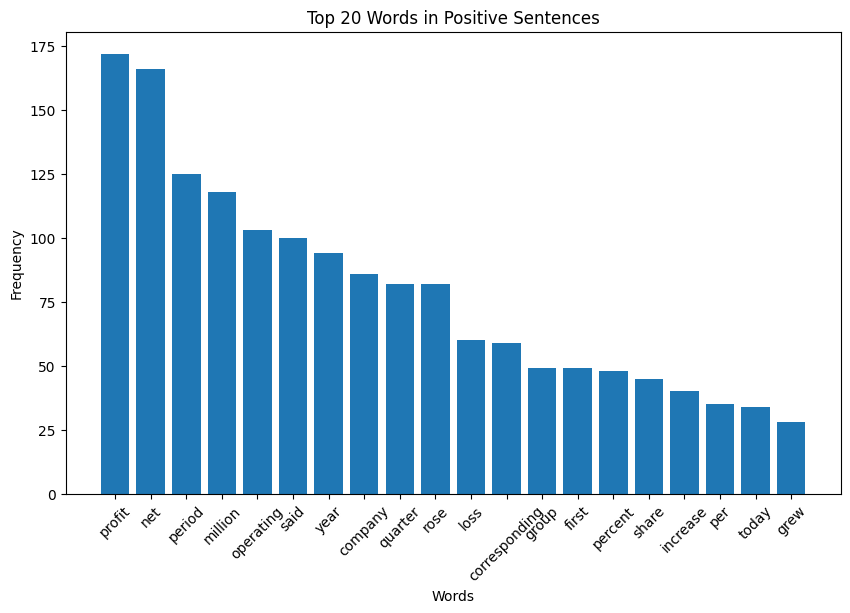

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(cleaned_df_pos.index[:20], cleaned_df_pos[:20])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Positive Sentences')
plt.xticks(rotation=45)
plt.show()

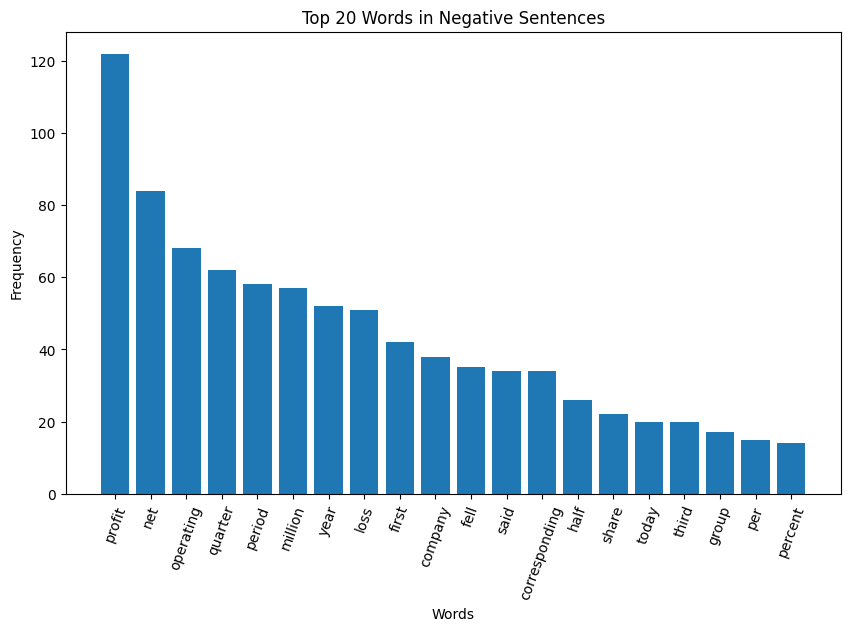

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(cleaned_df_neg.index[:20], cleaned_df_neg[:20])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Negative Sentences')
plt.xticks(rotation=70)
plt.show()

3. Class Imbalance and Word Count Analysis:

• Compute and visualize the frequency of each sentiment label with a bar graph.
Discuss class imbalance in the labels (1-2 sentences).

• Create box plots for word/token counts per sentiment label. Discuss discrepancies
(1-2 sentences)

In [ ]:
print(f'Negative sentiment: {cleaned_df_neg.shape[0]}')
print(f'Positive sentiment: {cleaned_df_pos.shape[0]}')

Negative sentiment: 541
Positive sentiment: 824


In the code above we can see that the exists class imbalance in the dataset. Class imbalance occurs when, in say a class of binary labels, there is a material difference in label counts. In this case, I cleaned the data and retained only meaningful text, which left me with 1,365 data points. Positive labels make up 60% of the labels, leaving the other 40% to negative labels. There is a greater likelihood of selecting a positive label in if random selection is used. In this situation, if I were looking to maximize model performance, I'd use undersampling to reduce the number of positive labels.

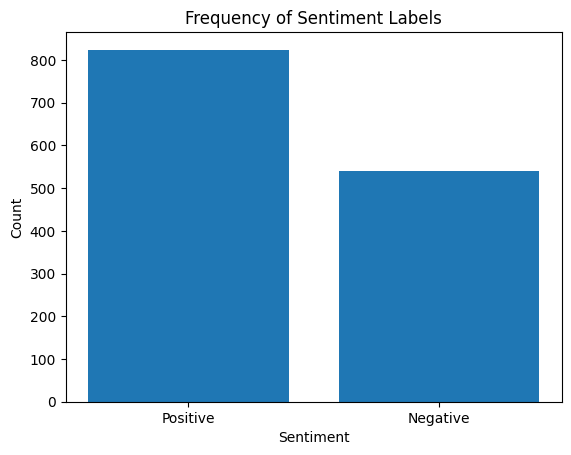

In [13]:
plt.bar(['Positive', 'Negative'], [cleaned_df_pos.shape[0], cleaned_df_neg.shape[0]])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Frequency of Sentiment Labels')
plt.show()

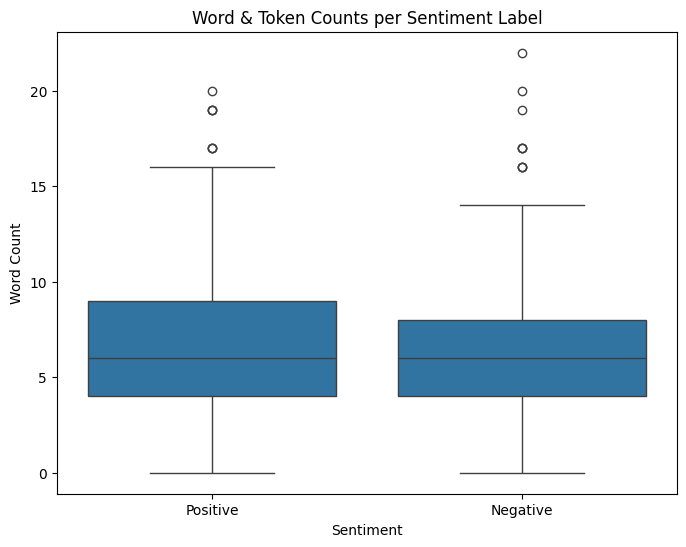

In [14]:
word_counts_pos = [len(sentence.split()) for sentence in processed_text_pos]
word_counts_neg = [len(sentence.split()) for sentence in processed_text_neg]

word_count_data = pd.DataFrame({'Sentiment': ['Positive'] * len(word_counts_pos) + ['Negative'] * len(word_counts_neg),
                                 'Word Count': word_counts_pos + word_counts_neg})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='Word Count', data=word_count_data)
plt.title('Word & Token Counts per Sentiment Label')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

### Discuss discrepancies (1-2 sentences)
The boxplots above analyze the word counts for each instance of a given sentiment. If we look at the positive sentiment we see that the range of word counts are greater than that of the negative postings. This suggests that people posting positive reviews use more words in their postings than those posting negative reviews.

### 4. Model Development and Evaluation:

• Split data into training (80%) and testing (20%) sets using stratified splitting
with a random seed of 64.

• Vectorization: Use CountVectorizer and Tf-Idf.

• Model Training: Employ Naive Bayes Model and logistic regression.

• Metrics Tracking: Present Accuracy, Precision, Recall, F1-Score for each
class, and an overall Confusion Matrix.

In [16]:
raw_data['Cleaned_Text'] = raw_data['Text'].apply(clean_sentence)

In [17]:
raw_data['Binary'] = raw_data['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [18]:
X = raw_data['Cleaned_Text']
y = raw_data['Binary']

### • Split data into training (80%) and testing (20%) sets using stratified splitting with a random seed of 64.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64, stratify=y)

### Vectorization: Use CountVectorizer and Tf-Idf.

In [20]:
vectorizer_count = CountVectorizer()
X_train_count = vectorizer_count.fit_transform(X_train)
X_test_count = vectorizer_count.transform(X_test)

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [ ]:
X_train_tfidf.shape

(1810, 2226)

### • Model Training: Employ Naive Bayes Model and logistic regression.

In [21]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [22]:
y_pred = model.predict(X_test_tfidf)

In [23]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       339
           1       0.90      0.46      0.61       114

    accuracy                           0.85       453
   macro avg       0.87      0.72      0.76       453
weighted avg       0.86      0.85      0.83       453



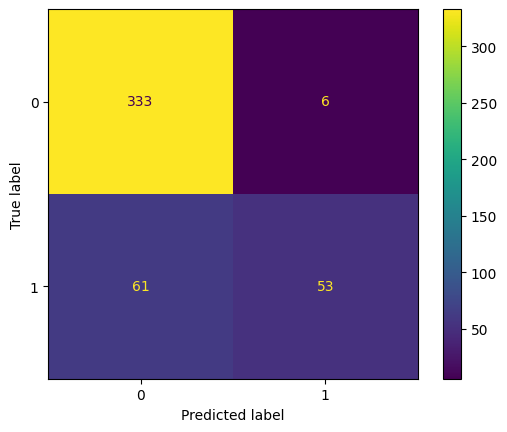

In [24]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()


In [25]:
# Logistic Regression with CountVectorizer
logreg_model = LogisticRegression()
logreg_model.fit(X_train_count, y_train)
y_pred_logreg_count = logreg_model.predict(X_test_count)

# Confusion Matrix for Logistic Regression with CountVectorizer
cm_logreg_count = confusion_matrix(y_test, y_pred_logreg_count)
print("Confusion Matrix for Logistic Regression with CountVectorizer:")
print(cm_logreg_count)


Confusion Matrix for Logistic Regression with CountVectorizer:
[[323  16]
 [ 55  59]]


              precision    recall  f1-score   support

           0       0.85      0.95      0.90       339
           1       0.79      0.52      0.62       114

    accuracy                           0.84       453
   macro avg       0.82      0.74      0.76       453
weighted avg       0.84      0.84      0.83       453



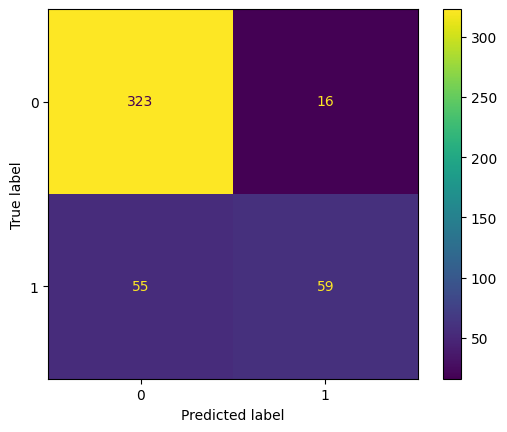

In [28]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train_count, y_train)
y_pred_logreg_count = logreg_model.predict(X_test_count)

print(classification_report(y_test, y_pred_logreg_count))
cm = confusion_matrix(y_test, y_pred_logreg_count)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg_model.classes_)
disp.plot()
plt.show()

### Model Training: Employ Naive Bayes Model.

In [29]:
model_gnb = GaussianNB()
model_gnb.fit(X_train_tfidf.toarray(), y_train);

In [30]:
y_pred_gnb = model_gnb.predict(X_test_tfidf.toarray())

              precision    recall  f1-score   support

           0       0.90      0.68      0.78       339
           1       0.45      0.77      0.57       114

    accuracy                           0.70       453
   macro avg       0.67      0.73      0.67       453
weighted avg       0.79      0.70      0.72       453



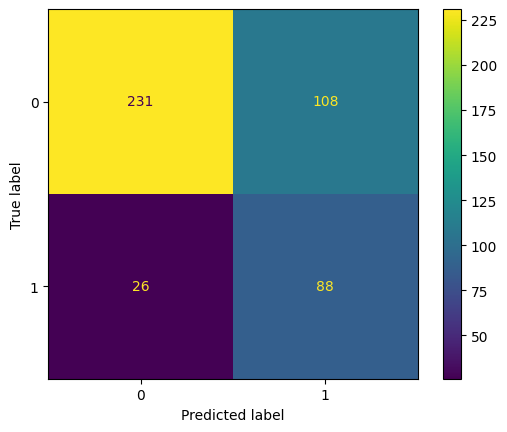

In [31]:
print(classification_report(y_test, y_pred_gnb))

cm = confusion_matrix(y_test, y_pred_gnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_gnb.classes_)
disp.plot()
plt.show()


              precision    recall  f1-score   support

           0       0.92      0.68      0.78       339
           1       0.46      0.82      0.59       114

    accuracy                           0.71       453
   macro avg       0.69      0.75      0.68       453
weighted avg       0.80      0.71      0.73       453



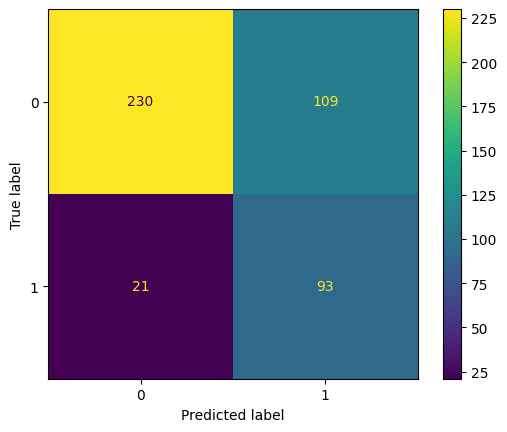

In [32]:
# Model Training: Employ Naive Bayes Model.
model_gnb_count = GaussianNB()
model_gnb_count.fit(X_train_count.toarray(), y_train);
y_pred_gnb_count = model_gnb_count.predict(X_test_count.toarray())
print(classification_report(y_test, y_pred_gnb_count))

cm = confusion_matrix(y_test, y_pred_gnb_count)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_gnb_count.classes_)
disp.plot()
plt.show()

## Question 2: Predicting Building Energy Efficiency

Tasks:

### 1. Data Preprocessing:

• Perform exploratory data analysis (EDA) after loading the dataset.

• Conduct feature engineering if necessary.

• Use a 70% training and 30% testing split, and set a random seed (e.g., 42) to
ensure reproducibility.

### 2. Target Variable Analysis:

• Separate the dataset to develop models for Heating Load and Cooling Load as
target variables.

• Prepare for model development for each target.

### 3. Model Development:

• Implement various regression models (Linear Regression, Ridge, Lasso, and
Elastic Net) for both target variables.

• Perform hyperparameter tuning for optimization.

### 4. Model Evaluation:

• Evaluate models using RMSE, MAE, and R² score.

• Assess performance on training and testing datasets for each target variable.

• Compare the effectiveness of models for Heating Load and Cooling Load.
Page 3

Deliverables:

• All code, analysis, and outputs.

• A report summarizing findings and model comparisons.

This assignment focuses on applying and evaluating regression analysis in a real-world
context, emphasizing feature selection, model optimization, and interpretation of results
in the context of building energy efficiency.


## 1. Data Preprocessing:

• Perform exploratory data analysis (EDA) after loading the dataset.


• Conduct feature engineering if necessary.


• Use a 70% training and 30% testing split, and set a random seed (e.g., 42) to ensure reproducibility.

In [ ]:
energy_data = pd.read_excel('ENB2012_data.xlsx')
energy_data.head(2)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33


In [ ]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


The info above shows that there are no null values in the dataset, so no need to hadle missing values.

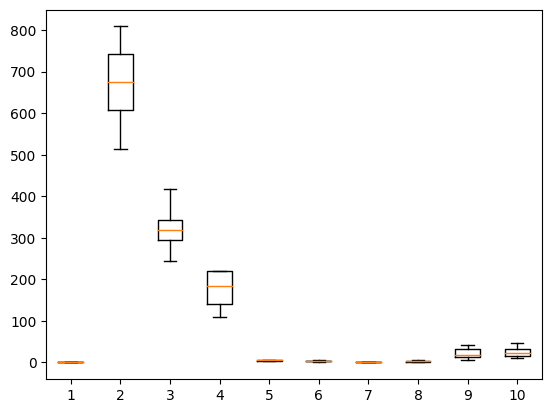

In [ ]:
plt.boxplot(energy_data)
plt.show()

The boxplot above shows there exists signficant differences in the data distribution however, this reinforces the need for scaling. Will likely use [0,1] scaling.

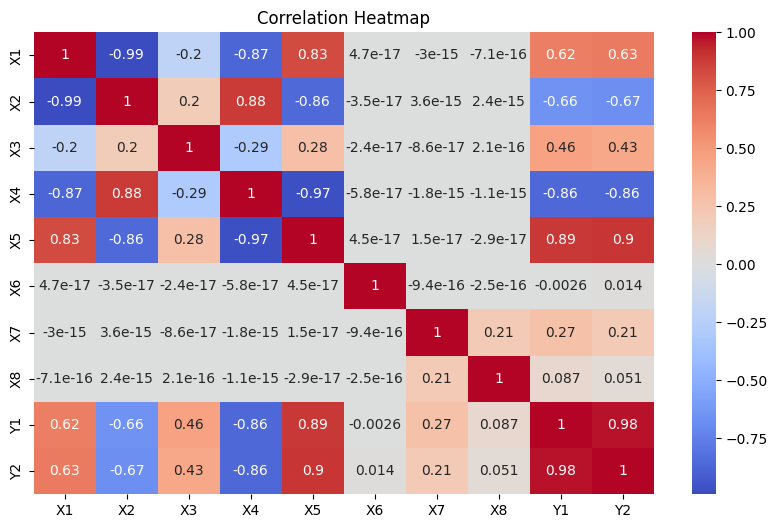

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(energy_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap above indicates that there exists multicollinearity in the dataset, therefore I could conduct feature importance after linear regreassion and possilbly remove highly correlated features to prevent overfitting due to variance inflation.

In [ ]:
X = energy_data.drop(['Y1', 'Y2'], axis=1)
y1 = energy_data['Y1'].rename('Heating Load')
y2 = energy_data['Y2'].rename('Cooling Load')

### • Use a 70% training and 30% testing split, and set a random seed (e.g., 42) to ensure reproducibility.

In [ ]:
X_train1, X_test1, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=42)
X_train2, X_test2, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=42)

## 2. Target Variable Analysis:

• Separate the dataset to develop models for Heating Load and Cooling Load as target variables.

• Prepare for model development for each target.

In [ ]:
X_train1_scaled = MinMaxScaler().fit_transform(X_train1)
X_test1_scaled = MinMaxScaler().fit_transform(X_test1)

X_train2_scaled = MinMaxScaler().fit_transform(X_train2)
X_test2_scaled = MinMaxScaler().fit_transform(X_test2)

In [ ]:
y1_train.info()

<class 'pandas.core.series.Series'>
Index: 537 entries, 334 to 102
Series name: Heating Load
Non-Null Count  Dtype  
--------------  -----  
537 non-null    float64
dtypes: float64(1)
memory usage: 8.4 KB


In [ ]:
y2_train.info()

<class 'pandas.core.series.Series'>
Index: 537 entries, 334 to 102
Series name: Cooling Load
Non-Null Count  Dtype  
--------------  -----  
537 non-null    float64
dtypes: float64(1)
memory usage: 8.4 KB



## 3. Model Development:

• Implement various regression models (Linear Regression, Ridge, Lasso, and Elastic Net) for both target variables.

• Perform hyperparameter tuning for optimization.

In [ ]:
"""# ***** Heating Load GridSearchCV ********
pipeline = Pipeline([
    ('model', LinearRegression())
])

param_grid = [
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False]
    },
    {
        'model': [Ridge()],
        'model__alpha': [0.1, 1.0, 10.0],
        'model__fit_intercept': [True, False]
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.01, 0.1, 1.0],
        'model__fit_intercept': [True, False]
    },
    {
        'model': [ElasticNet()],
        'model__alpha': [0.1, 1.0],
        'model__l1_ratio': [0.1, 0.5, 0.9],
        'model__fit_intercept': [True, False]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train1_scaled, y1_train)

print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)"""

'# ***** Heating Load GridSearchCV ********\npipeline = Pipeline([\n    (\'model\', LinearRegression())\n])\n\nparam_grid = [\n    {\n        \'model\': [LinearRegression()],\n        \'model__fit_intercept\': [True, False]\n    },\n    {\n        \'model\': [Ridge()],\n        \'model__alpha\': [0.1, 1.0, 10.0],\n        \'model__fit_intercept\': [True, False]\n    },\n    {\n        \'model\': [Lasso()],\n        \'model__alpha\': [0.01, 0.1, 1.0],\n        \'model__fit_intercept\': [True, False]\n    },\n    {\n        \'model\': [ElasticNet()],\n        \'model__alpha\': [0.1, 1.0],\n        \'model__l1_ratio\': [0.1, 0.5, 0.9],\n        \'model__fit_intercept\': [True, False]\n    }\n]\n\ngrid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\ngrid_search.fit(X_train1_scaled, y1_train)\n\nprint("Best estimator:", grid_search.best_estimator_)\nprint("Best parameters:", grid_search.best_params_)\nprint("Best cross-validation score (negative MSE)

## Linear Regression

In [ ]:
# Heating Load Linear Regression
param_grid = [
    {
        'fit_intercept': [True, False]
    }]
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train1_scaled, y1_train)
print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)

Best estimator: LinearRegression()
Best parameters: {'fit_intercept': True}
Best cross-validation score (negative MSE): -8.59708447064678
Test set performance (negative MSE): -8.83951594738464


In [ ]:
lin_heat = LinearRegression()
lin_heat.fit(X_train1_scaled, y1_train)
lin_heat_score = lin_heat.score(X_test1_scaled, y1_test)
print(f'Linear Regression Heating Score: {lin_heat_score}')

Linear Regression Heating Score: 0.912823046007594


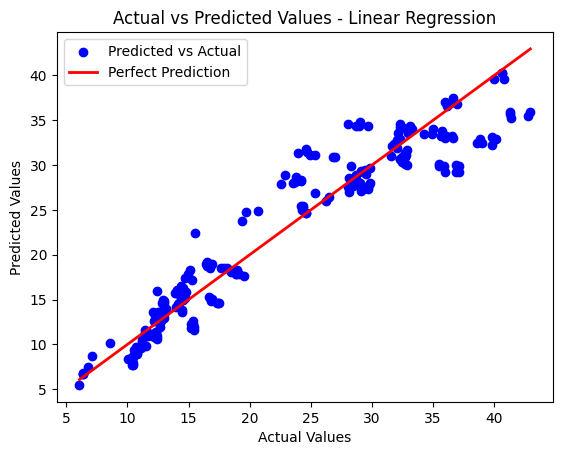

In [ ]:
y1_pred = lin_heat.predict(X_test1_scaled)
plt.scatter(y1_test, y1_pred, color='blue', label='Predicted vs Actual')
plt.plot([y1_test.min(), y1_test.max()], [y1_test.min(), y1_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Linear Regression')

plt.legend()

plt.show()


In [ ]:
# Cooling Load Linear Regression
param_grid = [
    {
        'fit_intercept': [True, False]
    }]
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train2_scaled, y2_train)
print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test2_scaled, y2_test)
print("Test set performance (negative MSE):", test_score)

Best estimator: LinearRegression()
Best parameters: {'fit_intercept': True}
Best cross-validation score (negative MSE): -10.373121342760049
Test set performance (negative MSE): -10.275135254701036


In [ ]:
lin_cool = LinearRegression()
lin_cool.fit(X_train2_scaled, y2_train)
lin_cool_score = lin_cool.score(X_test2_scaled, y2_test)
print(f'Linear Regression Cooling Score: {lin_cool_score}')

Linear Regression Cooling Score: 0.8860072950624993


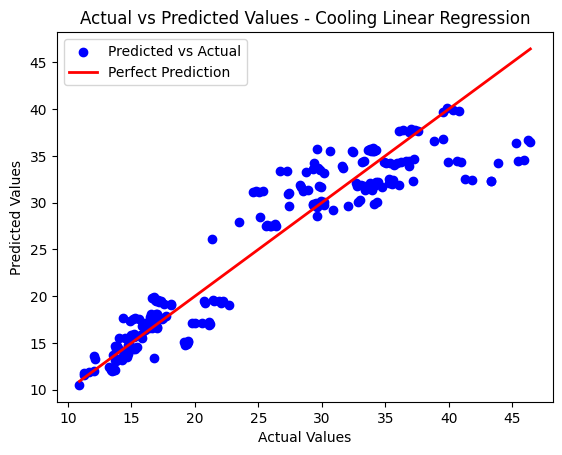

In [ ]:
y2_pred = lin_cool.predict(X_test2_scaled)
plt.scatter(y2_test, y2_pred, color='blue', label='Predicted vs Actual')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Cooling Linear Regression')

plt.legend()

plt.show()

## Ridge Regression

In [ ]:
# Heating Load Ridge Regression
param_grid = [
    {
        'alpha': [0.1, 1.0, 10.0],
        'fit_intercept': [True, False]
    }]
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train1_scaled, y1_train)
print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)

Best estimator: Ridge(alpha=0.1)
Best parameters: {'alpha': 0.1, 'fit_intercept': True}
Best cross-validation score (negative MSE): -8.639744199971561
Test set performance (negative MSE): -8.872308088842852


In [ ]:
heat_ridge = Ridge(alpha=0.1, fit_intercept=True)
heat_ridge.fit(X_train1_scaled, y1_train)
heat_ridge_score = heat_ridge.score(X_test1_scaled, y1_test)
print(f'Ridge Regression Heating Score: {heat_ridge_score}')

Ridge Regression Heating Score: 0.9124996437959536


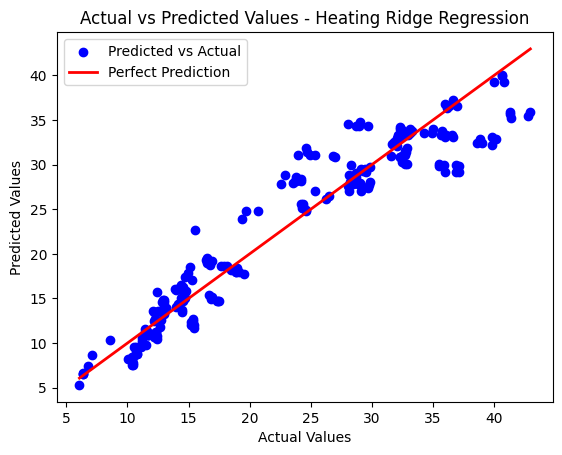

In [ ]:
y_pred_ridge = heat_ridge.predict(X_test1_scaled)
plt.scatter(y1_test, y_pred_ridge, color='blue', label='Predicted vs Actual')
plt.plot([y1_test.min(), y1_test.max()], [y1_test.min(), y1_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Heating Ridge Regression')

plt.legend()

plt.show()

In [ ]:
# Cooling Load Ridge Regression
param_grid = [
    {
        'alpha': [0.1, 1.0, 10.0],
        'fit_intercept': [True, False]
    }]
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train2_scaled, y2_train)
print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)

Best estimator: Ridge(alpha=0.1)
Best parameters: {'alpha': 0.1, 'fit_intercept': True}
Best cross-validation score (negative MSE): -10.416519949155916
Test set performance (negative MSE): -13.823709861144458


In [ ]:
ridge_cool = Ridge(alpha=0.1, fit_intercept=True)
ridge_cool.fit(X_train2_scaled, y2_train)
ridge_cool_score = ridge_cool.score(X_test2_scaled, y2_test)
print(f'Ridge Regression Cooling Score: {ridge_cool_score}')

Ridge Regression Cooling Score: 0.8858900988188294


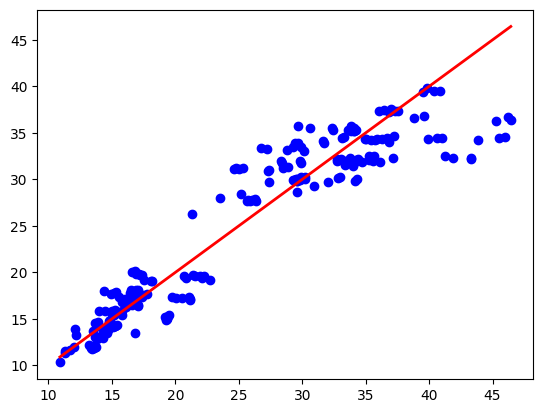

In [ ]:
y_pred_ridge = ridge_cool.predict(X_test2_scaled)
plt.scatter(y2_test, y_pred_ridge, color='blue', label='Predicted vs Actual')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], color='red', linewidth=2)


## Lasso Regression

In [ ]:
# Heating Load Lasso Regression
param_grid = [
    {
        'alpha': [0.1, 1.0, 10.0],
        'fit_intercept': [True, False]
    }
]

grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train1_scaled, y1_train)

print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)


Best estimator: Lasso(alpha=0.1, fit_intercept=False)
Best parameters: {'alpha': 0.1, 'fit_intercept': False}
Best cross-validation score (negative MSE): -9.11366439646829
Test set performance (negative MSE): -9.49874741122331


In [ ]:
lasso_heat = Lasso(alpha=0.1, fit_intercept=True)
lasso_heat.fit(X_train1_scaled, y1_train)
lasso_heat_score = lasso_heat.score(X_test1_scaled, y1_test)
print(f'Lasso Regression Heating Score: {lasso_heat_score}')

Lasso Regression Heating Score: 0.9050023301872129


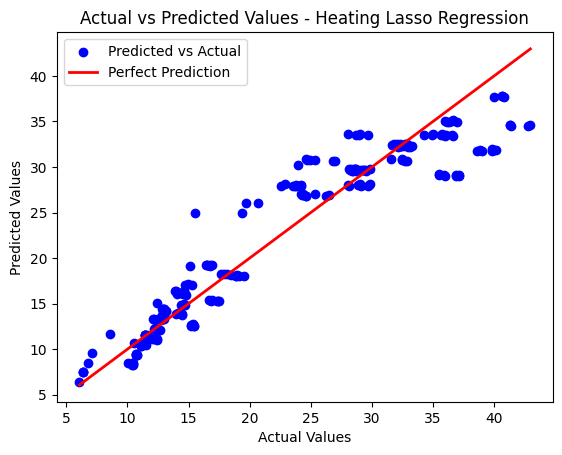

In [ ]:
y_pred_lasso_heat = lasso_heat.predict(X_test1_scaled)
plt.scatter(y1_test, y_pred_lasso_heat, color='blue', label='Predicted vs Actual')
plt.plot([y1_test.min(), y1_test.max()], [y1_test.min(), y1_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Heating Lasso Regression')

plt.legend()

plt.show()

In [ ]:
# Cooling Load Lasso Regression
param_grid = [
    {
        'alpha': [0.1, 1.0, 10.0],
        'fit_intercept': [True, False]
    }
]

grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train2_scaled, y2_train)

print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)


Best estimator: Lasso(alpha=0.1, fit_intercept=False)
Best parameters: {'alpha': 0.1, 'fit_intercept': False}
Best cross-validation score (negative MSE): -11.15456692307124
Test set performance (negative MSE): -13.19395834623718


In [ ]:
lasso_cool = Lasso(alpha=0.1, fit_intercept=True)
lasso_cool.fit(X_train2_scaled, y2_train)
lasso_cool_score = lasso_cool.score(X_test2_scaled, y2_test)
print(f'Lasso Regression Cooling Score: {lasso_cool_score}')

Lasso Regression Cooling Score: 0.8729931330917404


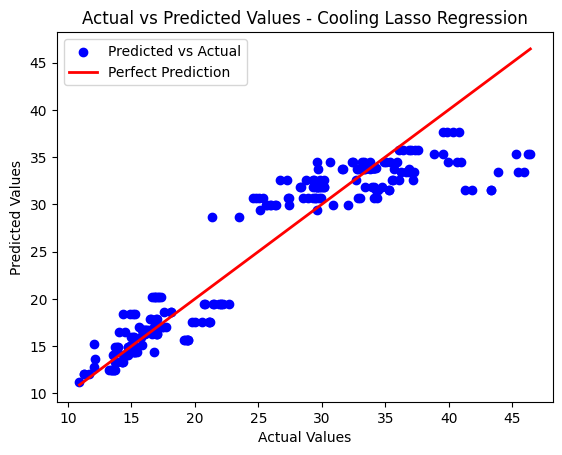

In [ ]:
y_pred_lasso_cool = lasso_cool.predict(X_test2_scaled)
plt.scatter(y2_test, y_pred_lasso_cool, color='blue', label='Predicted vs Actual')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Cooling Lasso Regression')

plt.legend()

plt.show()

## Elastic Net

In [ ]:
#The following is the Heating load Elastic Net GridSearch

param_grid = [
    {
        'alpha': [0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'fit_intercept': [True, False]
    }
]

grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train1_scaled, y1_train)

print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test1_scaled, y1_test)
print("Test set performance (negative MSE):", test_score)


Best estimator: ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.9)
Best parameters: {'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9}
Best cross-validation score (negative MSE): -9.393269152981823
Test set performance (negative MSE): -10.00562660028206


In [ ]:
en_heating = ElasticNet(alpha=0.1, l1_ratio=0.9, fit_intercept=False)
en_heating.fit(X_train1_scaled, y1_train)
en_heating_score = en_heating.score(X_test1_scaled, y1_test)
print(f'Elastic Net Heating Score: {en_heating_score}')

Elastic Net Heating Score: 0.9013226453812713


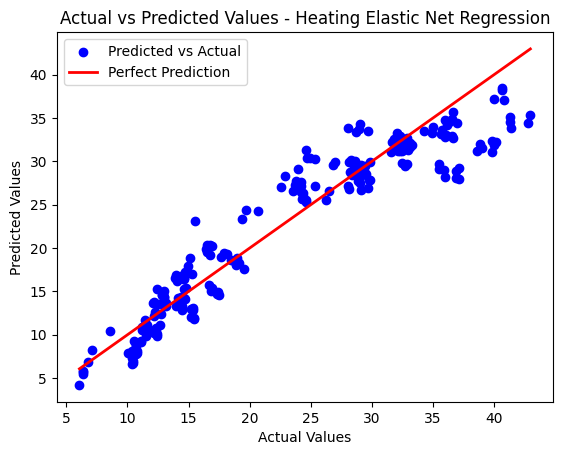

In [ ]:
plt.scatter(y1_test, en_heating.predict(X_test1_scaled), color='blue', label='Predicted vs Actual')
plt.plot([y1_test.min(), y1_test.max()], [y1_test.min(), y1_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Heating Elastic Net Regression')

plt.legend()

plt.show()

In [ ]:
#The following is the Cooling Load Elastic Net GridSearch


param_grid = [
    {
        'alpha': [0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'fit_intercept': [True, False]
    }
]

grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train2_scaled, y2_train)

print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

test_score = grid_search.score(X_test2_scaled, y2_test)
print("Test set performance (negative MSE):", test_score)


Best estimator: ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.9)
Best parameters: {'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.9}
Best cross-validation score (negative MSE): -11.458983743060653
Test set performance (negative MSE): -11.727521857227392


In [ ]:
en_cooling = ElasticNet(alpha=0.1, l1_ratio=0.9, fit_intercept=False)
en_cooling.fit(X_train2_scaled, y2_train)
en_cooling_score = en_cooling.score(X_test2_scaled, y2_test)
print(f'Elastic Net Cooling Score: {en_cooling_score}')

Elastic Net Cooling Score: 0.8698944679966737


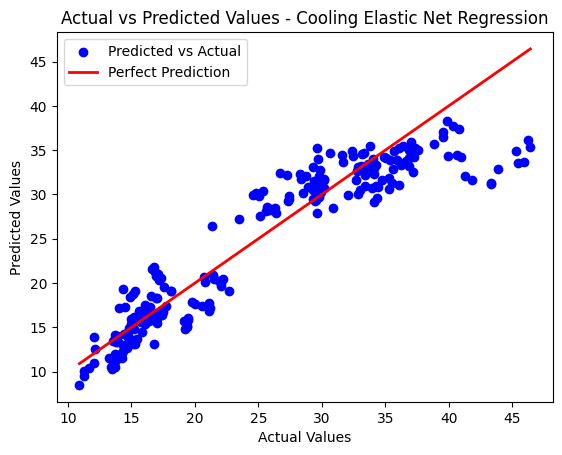

In [ ]:
y_pred_en_cooling = en_cooling.predict(X_test2_scaled)
plt.scatter(y2_test, y_pred_en_cooling, color='blue', label='Predicted vs Actual')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Cooling Elastic Net Regression')

plt.legend()

plt.show()

In [ ]:
model_names = ['Linear Regression', 'Lasso', 'Ridge', 'Elastic Net']
heating_scores = [lin_heat_score, lasso_heat_score, heat_ridge_score, en_heating_score]
cooling_scores = [lin_cool_score, lasso_cool_score, ridge_cool_score, en_cooling_score]

model_df = pd.DataFrame({'Model': model_names, 'Heating Load Score': heating_scores, 'Cooling Load Score': cooling_scores})
print(model_df)


               Model  Heating Load Score  Cooling Load Score
0  Linear Regression            0.912823            0.886007
1              Lasso            0.905002            0.872993
2              Ridge            0.912500            0.885890
3        Elastic Net            0.901323            0.869894


## Regression Model Assessments
If we observe the dataframe above, we see model scores for each of the assessed regression models. Each model was hyperparameter tuned with gridsearchcv prior to the model's implemenation. We can see that each model did indeed perform well. The best scoring model on the Heating Load and Cooling Load is the Linear Regression model.

# 4. Model Evaluation:

• Evaluate models using RMSE, MAE, and R² score.

• Assess performance on training and testing datasets for each target variable.

• Compare the effectiveness of models for Heating Load and Cooling Load.

In [ ]:
def calculate_metrics(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  return rmse, mae, r2

models = {
    'Linear Regression (Heating)': (lin_heat, y1_test, y1_pred),
    'Ridge Regression (Heating)': (heat_ridge, y1_test, y_pred_ridge),
    'Lasso Regression (Heating)': (lasso_heat, y1_test, y_pred_lasso_heat),
    'Elastic Net (Heating)': (en_heating, y1_test, en_heating.predict(X_test1_scaled)),
    'Linear Regression (Cooling)': (lin_cool, y2_test, y2_pred),
    'Ridge Regression (Cooling)': (ridge_cool, y2_test, y_pred_ridge),
    'Lasso Regression (Cooling)': (lasso_cool, y2_test, y_pred_lasso_cool),
    'Elastic Net (Cooling)': (en_cooling, y2_test, y_pred_en_cooling)
}

results = []
for model_name, (model, y_true, y_pred) in models.items():
  rmse, mae, r2 = calculate_metrics(y_true, y_pred)
  results.append([model_name, rmse, mae, r2])

metrics_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R²'])
print(metrics_df)


                         Model      RMSE       MAE        R²
0  Linear Regression (Heating)  2.973132  2.155164  0.912823
1   Ridge Regression (Heating)  3.718025  3.020654  0.863668
2   Lasso Regression (Heating)  3.103630  2.208307  0.905002
3        Elastic Net (Heating)  3.163167  2.367782  0.901323
4  Linear Regression (Cooling)  3.205485  2.258098  0.886007
5   Ridge Regression (Cooling)  3.207133  2.257945  0.885890
6   Lasso Regression (Cooling)  3.383521  2.383523  0.872993
7        Elastic Net (Cooling)  3.424547  2.514028  0.869894


# RMSE - MAE - R2 Evaluation
Evaluating he RMSE, MAE, and R2 of the Heating Load and Cooling Load regression models, we find that the Linear Regression model overal performed the best by slight margins. Linear Regression performed the best on the heating load model across all three metrics. However the ridge regression model had a better MAE than linear regression by just 1/1000th of a point. Thus, overall, the most performant model would be the linear regression model.